# Ensemble run seed 202 of Case 1: Evaluate model results (confusion matrices, UMAPs of 8th layer activations, LOF scores, image visualizations, screening hits investigations, etc.)

<b> What is our goal? <b>

The main goal is to develop a model that has meaningful uncertainty, meaning the uncertainty is low for known and biologically uninteresting classes, but high for unknown and ideally biologically interesting classes. Our hope would be that this new model learns something the original classifier (autophagy_2_1 from SPACRSpy) did not, thereby identifying something new.
The way to test this for the multi-class classifier is by leaving out different biological conditions during training and then checking uncertainty on them as well as by evaluate the new model with screening data, plotting its 8th layer in UMAP and investigating the classifcation scores between the old and new models.

<b> What have we done so far? <b>

We retrained our de novo model on a different subset of each class 5 times via random subset with 5 different seeds. Specifically, for each run, we randomly sample 75,000 instances per class (e.g., 0 and 2 in the first case), train the de novo classifier on these subsets and save the resulting models. Repeat this for five iterations, ensuring the random subsets differ in each run. After training, we evaluate the models on a balanced test set containing 2000 instances from all 6 biological classes and compare performance across the different iterations. Then, we investigate the uncertainty. scores of the models, focusing on how they classify both known and unknown biological classes.
We do this all for Case 1 (0,2 for training, and all other classes in test).

<b> What data do we have now? <b>

1. Stimulated 14h (or 16h) -> labelled as 0
2. Unstimulated -> labelled as 1
3. ATG5 KO (stimulated but that doesn’t matter, this KO supersedes the stim status [probably looks like unstimulated data]) -> labelled as 2
4. Stimulated timecourse data -> labelled as 3
5. EI24 KO timecourse data (more similar to unstim) -> labelled as 4
6. Screening data (similar to stim) -> labelled as 5


<b> What are we doing in this section? <b>

Here we investigate the model results for Case 1 seed 202 from our ensembling process (confusion matrices, UMAPs of 8th layer activations, LOF scores, image visualizations, screening hits investigations, etc.).


<b> What to do from here? <b>

1. We could also try the LOF as a score. By applying LOF we can gain an additional layer of confidence in identifying truly novel phenotypes. LOF helps differentiate between points that are genuine anomalies and those that are within expected variability. 
2. After training the five models, we could ensemble them by averaging their predictions or using a majority vote for classification. This will help smooth out individual model variability and may highlight outliers or new patterns.
3. We want to run Case 8 (0,2,4|test everything) as a positive control.
4. We could run uncertainty on 3 or 4 classes (our other cases) and have a statistic on how well we do as we increase number of classes and ideally find a nice list of cell ids to excise which contain a novel phenotype.


In [1]:
!pip install torch-intermediate-layer-getter
!pip install umap-learn
!pip install leidenalg
!pip install scanpy==1.9.6
!pip install anndata umap-learn
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command

In [2]:
!pip install nexusformat

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 79 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 45.6 MB 5.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
%load_ext watermark
 
import os
import wandb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import sys
import seaborn as sn
from torch.utils.tensorboard import SummaryWriter
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import umap
import scanpy as sc
import anndata as ad
import re
from collections import Counter
import random
from torch.utils.data import Subset
import h5py
import random
import pickle
import glob

from sparcscore.ml.datasets import HDF5SingleCellDataset
# from sparcscore.pipeline.project import TimecourseProject, Project
# from sparcscore.pipeline.workflows import MultithreadedWGATimecourseSegmentation, WGATimecourseSegmentation, MultithreadedCytosolCellposeTimecourseSegmentation, ShardedWGASegmentation, ShardedDAPISegmentationCellpose, WGASegmentation, DAPISegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction, TimecourseHDF5CellExtraction
from sparcscore.pipeline.classification import MLClusterClassifier
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

NOTE! Installing ujson may make loading annotations faster.


In [2]:
from torch.utils.data import Dataset
import torch
import numpy as np
import random
import os
import h5py
   
class HDF5SingleCellDataset(Dataset):
    """
    Class for handling SPARCSpy single cell datasets stored in HDF5 files.

    This class provides a convenient interface for SPARCSpy formated hdf5 files containing single cell datasets. It supports loading data
    from multiple hdf5 files within specified directories, applying transformations on the data, and returning
    the required information, such as label or id, along with the single cell data.

    Attributes
    ----------
    root_dir : str
        Root directory where the hdf5 files are located.
    dir_labels : list of int
        List of labels corresponding to the directories in dir_list.
    dir_list : list of str
        List of path(s) where the hdf5 files are stored. Supports specifying a path to a specific hdf5 file or directory
        containing hdf5 files.
    transform : callable, optional
        A optional user-defined function to apply transformations to the data. Default is None.
    max_level : int, optional
        Maximum levels of directory to search for hdf5 files. Default is 5.
    return_id : bool, optional
        Whether to return the index of the cell with the data. Default is False.
    return_fake_id : bool, optional
        Whether to return a fake index (0) with the data. Default is False.
    select_channel : int, optional
        Specify a specific channel to select from the data. Default is None, which returns all channels.

    Methods
    -------
    add_hdf_to_index(current_label, path)
        Adds single cell data from the hdf5 file located at ‘path’ with the specified ‘current_label’ to the index.
    scan_directory(path, current_label, levels_left)
        Scans directories for hdf5 files and adds their data to the index with the specified ‘current_label’.
    stats()
        Prints dataset statistics including total count and count per label.
    len()
        Returns the total number of single cells in the dataset.
    getitem(idx)
        Returns the data, label, and optional id/fake_id of the single cell specified by the index ‘idx’.

    Examples
    --------
    >>> hdf5_data = HDF5SingleCellDataset(dir_list=[‘data1.hdf5’, ‘data2.hdf5’],
    dir_labels=[0, 1],
    root_dir=‘/path/to/data’,
    transform=None,
    return_id=True)
    >>> len(hdf5_data)
    2000
    >>> sample = hdf5_data[0]
    >>> sample[0].shape
    torch.Size([1, 128, 128])
    >>> sample[1]
    tensor(0)
    >>> sample[2]
    tensor(0)

    """
    
    HDF_FILETYPES = ["hdf", "hf", "h5", "hdf5"]
    def __init__(self, dir_list, 
                 dir_labels, 
                 root_dir, 
                 max_level=5, 
                 transform=None, 
                 return_id=False, 
                 return_fake_id=False,
                 select_channel=None):
        
        self.root_dir = root_dir
        self.dir_labels = dir_labels
        self.dir_list = dir_list
        self.transform = transform
        
        self.handle_list = []
        self.data_locator = []
        
        self.select_channel = select_channel
        
        # scan all directoreis
        for i, directory in enumerate(dir_list):
            path = os.path.join(self.root_dir, directory)  
            current_label = self.dir_labels[i]

            #check if "directory" is a path to specific hdf5
            filetype = directory.split(".")[-1]
            filename = directory.split(".")[0]
                
            if filetype in self.HDF_FILETYPES:
                self.add_hdf_to_index(current_label, directory)

            else:
                # recursively scan for files
                self.scan_directory(path, current_label, max_level)
        
        # print dataset stats at the end
        
        self.return_id = return_id
        self.return_fake_id = return_fake_id
        self.stats()
 
        
    def add_hdf_to_index(self, current_label, path):       
        try:
            input_hdf = h5py.File(path, 'r')
            index_handle = input_hdf.get('single_cell_index')

            handle_id = len(self.handle_list)
            self.handle_list.append(input_hdf.get('single_cell_data'))

            for row in index_handle:
                self.data_locator.append([current_label, handle_id]+list(row))      
        except:
            return
        
    def scan_directory(self, path, current_label, levels_left):
        
        # iterates over all files and folders in a directory
        # hdf5 files are added to the index
        # subfolders are recursively scanned
        
        if levels_left > 0:
            
            # get files and directories at current level
            input_list = os.listdir(path)
            current_level_directories = [os.path.join(path, name) for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

            current_level_files = [ name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]
                        
            for i, file in enumerate(current_level_files):
                filetype = file.split(".")[-1]
                filename = file.split(".")[0]
                
                if filetype in self.HDF_FILETYPES:
                    
                    self.add_hdf_to_index(current_label, os.path.join(path, file))
                    
            # recursively scan subdirectories        
            for subdirectory in current_level_directories:
                self.scan_directory(subdirectory, current_label, levels_left-1)
            
        else:
            return
        
    def stats(self):
    
        labels = [el[0] for el in self.data_locator]
        
        print("Total: {}".format(len(labels)))
        
        for l in set(labels):
            print("{}: {}".format(l,labels.count(l)))
        
    def __len__(self):
        return len(self.data_locator)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get the label, filename and directory for the current dataset
        data_info = self.data_locator[idx]
        
        if self.select_channel is not None:
            cell_tensor = self.handle_list[data_info[1]][data_info[2], self.select_channel]
            t = torch.from_numpy(cell_tensor)
            t = torch.unsqueeze(t,0)
            
        else:
            
            cell_tensor = self.handle_list[data_info[1]][data_info[2]]
            t = torch.from_numpy(cell_tensor)
            
        t = t.float()     
        
        if self.transform:
            t = self.transform(t)
        """  
        if not list(t.shape) == list(torch.Size([1,128,128])):
            t = torch.zeros((1,128,128))
        """      
        if self.return_id and self.return_fake_id:
            raise ValueError("either return_id or return_fake_id should be set")
            
        if self.return_id:
            
            ids = int(data_info[3])
            sample = (t, torch.tensor(data_info[0]), torch.tensor(ids))
        elif self.return_fake_id:
            
            sample = (t, torch.tensor(data_info[0]), torch.tensor(0))
        else:
            sample = (t, torch.tensor(data_info[0]))
        
        return sample

In [3]:
# Function to load saved dataset and recreate DataLoader
def load_dataset(save_path, batch_size):
    # Load the saved tensor data
    images_tensor, labels_tensor = torch.load(save_path)
    
    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)
    
    # Create DataLoader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    print(f"Loaded dataset from {save_path}")
    return data_loader

In [4]:
class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassClassifier, self).__init__()
        
        # VGG-like feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier head for multi-class
        self.fc_input_size = 8192 
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes) 
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        # Print the size of x to confirm it's correct
        #print("Size of x:", x.size())
        
        x = self.classifier(x)
        return x

# Create an instance of the model
num_classes = 6
model = MultiClassClassifier(num_classes)
print(model)

MultiClassClassifier(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (

In [5]:
batch_size = 256                    # Batch size for DataLoader

## Confusion matrix 

In [6]:
# Define the number of classes (must match what was used during training)
num_classes = 6

# Reinitialize the model architecture (same as during training)
model = MultiClassClassifier(num_classes)

# Specify the device (same as during training)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Load the balanced testset
test_data_loader = load_dataset("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt", batch_size)


seed = 202 

try:
    model.load_state_dict(torch.load(f'ensemble_multi_class_VGG2_case1_seed_{seed}.pth'))
    print(f"Model for seed {seed} successfully loaded.")
except Exception as e:
    print(f"Error loading model for seed {seed}: {str(e)}")

Loaded dataset from /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt
Model for seed 202 successfully loaded.


In [7]:
# Create DataLoader for test_data
batch_size = 256 
#test_data_loader = DataLoader(test_data_loader, batch_size=batch_size, shuffle=False)

# Initialize TensorBoard writer
tensorboard_writer = SummaryWriter('runs/ensemble_seed_202_VGG2_autophagy_confusion_matrix')

# Test loop
model.eval()
all_test_labels = []
all_test_predicted = []

with torch.no_grad():
    for data, labels in test_data_loader:
        data = data.to(device)
        labels = labels.to(device)

        output = model(data)
        _, predicted = output.max(1)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predicted.extend(predicted.cpu().numpy())

# Calculate  confusion matrix
confusion_matrix_result = confusion_matrix(all_test_labels, all_test_predicted)

# Print cm to console
print("Seed 202 Confusion Matrix:")
print(confusion_matrix_result)

# Save confusion matrix to TensorBoard
epsilon = 1e-8
num_classes = 6

class_names = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Screening"]
df_cm = pd.DataFrame(confusion_matrix_result / (confusion_matrix_result.sum(axis=1)[:, None] + epsilon),
                     index=class_names,
                     columns=class_names)

plt.figure(figsize=(10, 8)) 

# Plot confusion matrix
sn.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# save confusion matrix to TensorBoard
tensorboard_writer.add_figure('Confusion Matrix', plt.gcf())

# save confusion matrix to file
df_cm.to_csv('ensemble_seed_202_confusion_matrix_case1_with_screendata.csv', index=True)

# Close TensorBoard writer aggain
tensorboard_writer.close()

Seed 202 Confusion Matrix:
[[1267    0  733    0    0    0]
 [ 252    0 1748    0    0    0]
 [ 149    0 1851    0    0    0]
 [  20    0 1980    0    0    0]
 [1443    0  557    0    0    0]
 [1980    0   20    0    0    0]]


The confusion matrix shows how well the model, which was trained only on classes 0 and 2, performs when tested on all six classes. Each row of the confusion matrix represents the actual class (ground truth), while each column represents the predicted class by the model.

Since the model hasn't been exposed to classes 1, 3, 4, and 5 during training, its performance on these unseen classes will be poor or nonexistent.

We see that we have a) strong Bias Toward Classes 0 and 2 and b) poor Generalization to Unseen Classes.

In [8]:
# Get the total number of instances in the dataset
num_instances = len(test_data_loader.dataset)

print(f"Total number of instances in test_data_loader: {num_instances}")

Total number of instances in test_data_loader: 12000


In [9]:
original_dataset = test_data_loader.dataset  # Access the underlying dataset from the DataLoader

layer_name = 'features.24' # 8th layer activations name from model architecture

# define the return layers for IntermediateLayerGetter
return_layers = {layer_name: layer_name}

# Initialize the model with correct feature output
mid_getter = MidGetter(model, return_layers=return_layers, keep_output=True)

# Define the size of the subset!!! (not full dataset here due to kernal crahsing!)
subset_size = 12000 

# Create DataLoader
batch_size = 256

# Randomly sample a subset of the dataset
subset_indices = torch.randperm(len(original_dataset))[:subset_size]
torch.save(subset_indices, 'ensemble_seed_202_Case_1_subset_indices.pth')
subset_indices = torch.load('ensemble_seed_202_Case_1_subset_indices.pth')

# Create a new subset sampler with the loaded indices
subset_sampler = SubsetRandomSampler(subset_indices)

# Create a new DataLoader for the subset
subset_data_loader = DataLoader(original_dataset, batch_size=batch_size, sampler=subset_sampler)

# Lists to store activations and labels
activations = []
labels = []

# Forward pass of subset through the model to get activations
with torch.no_grad():
    for data, label in tqdm(subset_data_loader, desc="Processing data", leave=False):
        data = data.to(device) 
        mid_outputs, _ = mid_getter(data)
        # Get the activations
        activations.append(mid_outputs[layer_name].cpu().detach().numpy())
        labels.append(label.numpy())

# Concatenate activations and labels from all batches
activations = np.concatenate(activations, axis=0)
labels = np.concatenate(labels, axis=0)

Processing data:   0%|          | 0/47 [00:00<?, ?it/s]

In [10]:
#save activations and labels to files
np.save('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/ensemble_seed_202_Case_1_junk_activations_layer_8.npy', activations)
np.save('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/ensemble_seed_202_Case_1_junk_labels_layer_8.npy', labels)

In [ ]:
#lload activations and labels from files
activations = np.load('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/ensemble_seed_202_Case_1_junk_activations_layer_8.npy')
labels = np.load('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/autophagy_models/ensemble_seed_202_Case_1_junk_labels_layer_8.npy')
labels

In [11]:
# Reshape activations to 2 dims
activations_flat = activations.reshape(activations.shape[0], -1)
activations_flat

array([[0.49314025, 0.24517258, 0.34912208, ..., 0.        , 0.        ,
        0.        ],
       [0.48299682, 0.23085055, 0.32335138, ..., 0.        , 0.        ,
        0.        ],
       [0.49292374, 0.2862086 , 0.23480923, ..., 0.09248283, 0.        ,
        0.        ],
       ...,
       [0.4668475 , 0.17714266, 0.17625615, ..., 0.        , 0.        ,
        0.        ],
       [0.56475496, 0.4015878 , 0.5052561 , ..., 0.        , 0.        ,
        0.        ],
       [0.4838394 , 0.1274131 , 0.        , ..., 0.60861915, 0.        ,
        0.        ]], dtype=float32)

In [12]:
%matplotlib inline

# Calc. UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(activations_flat)

# Define new class labels 
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Screening"]

In [13]:
# Create AnnData object
adata = ad.AnnData(X=umap_result)

# Map numerical labels to string labels
label_map = {i: label for i, label in enumerate(class_labels)}

# Add .obs infos
adata.obs['class_labels'] = labels
adata.obs['class_labels'] = adata.obs['class_labels'].map(label_map)

# Run leiden and make UMAP
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

# define a custom discrete colormaps
colors_leiden = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
cmap_leiden = ListedColormap(colors_leiden, name='custom_discrete_cmap_leiden')

colors_class_labels = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
cmap_class_labels = ListedColormap(colors_class_labels, name='custom_discrete_cmap_class_labels')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


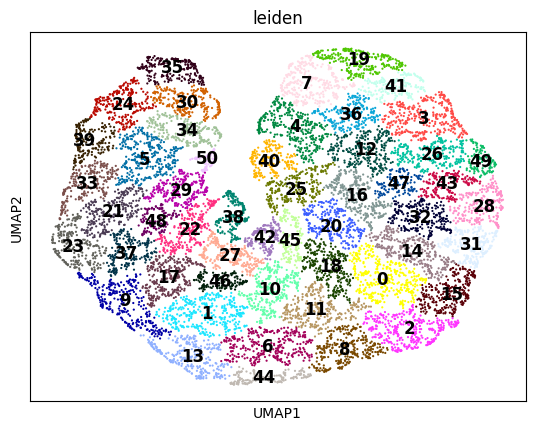

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


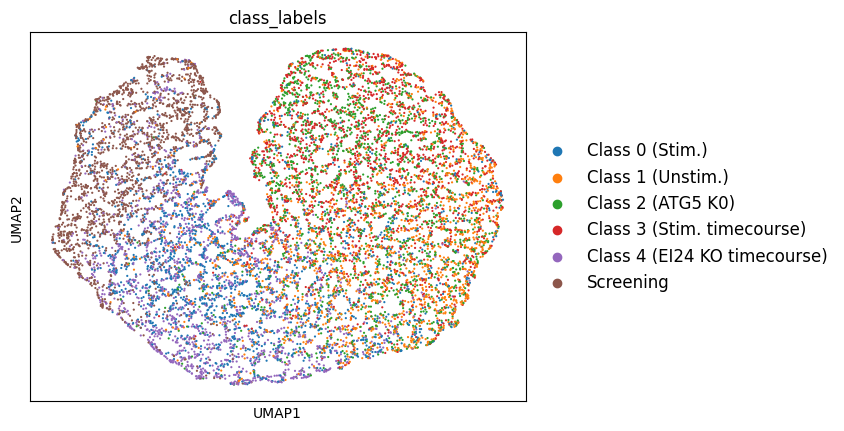

In [14]:
sc.pl.umap(adata, color=['leiden'], cmap=cmap_leiden, legend_loc='on data', legend_fontsize=12)
sc.pl.umap(adata, color=['class_labels'], cmap=cmap_class_labels, legend_loc='right margin', legend_fontsize=12)

In [15]:
"""# Get the cell IDs of screening class 3 cells from the subset
screening_cells = adata[adata.obs['class_labels'] == 'Screening'].obs_names
print("Cell IDs of screening class 3 cells:")
print(screening_cells)"""

'# Get the cell IDs of screening class 3 cells from the subset\nscreening_cells = adata[adata.obs[\'class_labels\'] == \'Screening\'].obs_names\nprint("Cell IDs of screening class 3 cells:")\nprint(screening_cells)'

In [16]:
"""# Subset adata to include only the selected Leiden clusters
selected_clusters = ["23", "12", "18", "25", "14", "17", "15", "28", "3", "1", "11", "21", "13", "39", "35", "10"]
adata_subset = adata[adata.obs['leiden'].isin(selected_clusters)]

# Get the cell IDs of screening class 3 cells within the subset
screening_indices = adata_subset[adata_subset.obs['class_labels'] == 'Class 3 (Screening)'].obs_names

# Print the cell IDs of screening class 3 cells within the selected Leiden clusters
print("Cell indices of screening class 3 cells within the selected Leiden clusters:")
print(screening_indices)

# Calculate the number of resulting screening indices
num_screening_indices = len(screening_indices)
print("Number of screening indices:", num_screening_indices)"""

'# Subset adata to include only the selected Leiden clusters\nselected_clusters = ["23", "12", "18", "25", "14", "17", "15", "28", "3", "1", "11", "21", "13", "39", "35", "10"]\nadata_subset = adata[adata.obs[\'leiden\'].isin(selected_clusters)]\n\n# Get the cell IDs of screening class 3 cells within the subset\nscreening_indices = adata_subset[adata_subset.obs[\'class_labels\'] == \'Class 3 (Screening)\'].obs_names\n\n# Print the cell IDs of screening class 3 cells within the selected Leiden clusters\nprint("Cell indices of screening class 3 cells within the selected Leiden clusters:")\nprint(screening_indices)\n\n# Calculate the number of resulting screening indices\nnum_screening_indices = len(screening_indices)\nprint("Number of screening indices:", num_screening_indices)'

In [17]:
"""# Define colors for class labels
colors = {'Class 0 (Stim.)': 'grey', 
          'Class 1 (Unstim.)': 'grey', 
          'Class 2 (ATG5 K0)': 'grey', 
          'Class 3 (Screening)': 'red'}

#filter only screening class 3 cells within selected Leiden clusters and plot UMAP
mask = (adata.obs['class_labels'] == 'Class 3 (Screening)') & (adata.obs['leiden'].isin(selected_clusters))
plt.figure(figsize=(10, 8))
for label, color in colors.items():
    if label == 'Class 3 (Screening)':
        plt.scatter(adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1], c=color, label=label, s=5)
    else:
        plt.scatter(adata.obsm['X_umap'][~mask, 0], adata.obsm['X_umap'][~mask, 1], c=color, label=label, s=5)

plt.title('UMAP showing Screening Class 3 Cells within Selected Leiden Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()"""

"# Define colors for class labels\ncolors = {'Class 0 (Stim.)': 'grey', \n          'Class 1 (Unstim.)': 'grey', \n          'Class 2 (ATG5 K0)': 'grey', \n          'Class 3 (Screening)': 'red'}\n\n#filter only screening class 3 cells within selected Leiden clusters and plot UMAP\nmask = (adata.obs['class_labels'] == 'Class 3 (Screening)') & (adata.obs['leiden'].isin(selected_clusters))\nplt.figure(figsize=(10, 8))\nfor label, color in colors.items():\n    if label == 'Class 3 (Screening)':\n        plt.scatter(adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1], c=color, label=label, s=5)\n    else:\n        plt.scatter(adata.obsm['X_umap'][~mask, 0], adata.obsm['X_umap'][~mask, 1], c=color, label=label, s=5)\n\nplt.title('UMAP showing Screening Class 3 Cells within Selected Leiden Clusters')\nplt.xlabel('UMAP 1')\nplt.ylabel('UMAP 2')\nplt.legend()\nplt.show()"

In [18]:
"""screening_indices = ['241', '338', '426', '492', '498', '505', '703', '733', '880', '915',
       '1177', '1278', '1394', '1495', '1585', '1605', '1776', '1896', '1950',
       '2109', '2185', '2195', '2296', '2342', '2482', '2553', '2599', '2674',
       '3185', '3296', '3552', '3727', '4038', '4432', '4634', '4663', '4718',
       '4720', '4895', '4933', '4956', '4976', '5004', '5051', '5128', '5146',
       '5165', '5166', '5286', '5413', '5609', '5718', '5763', '5782', '5811',
       '5853', '5863', '6079', '6082', '6106', '6176', '6263', '6325', '6340',
       '6405', '6487', '6707', '6774', '6791', '6899', '7089', '7116', '7171',
       '7258']

# Convert cell IDs to indices
screening_indices = [int(idx) for idx in screening_indices]
print(len(screening_indices))

# Just double-checking here...
# Obtain data for screening cells and print infos
screening_cells_data = [case1_hdf5_test_data[idx] for idx in screening_indices]
for idx, sample in zip(screening_indices, screening_cells_data):
    print(f"Cell ID: {idx}")
    #print(f"Data: {sample[0]}")  # Acces data
    print(f"Label: {sample[1]}")  # Access label
    if len(sample) == 3:
        print(f"ID: {sample[2]}")  # Access ID if available
    print("="*20)"""

'screening_indices = [\'241\', \'338\', \'426\', \'492\', \'498\', \'505\', \'703\', \'733\', \'880\', \'915\',\n       \'1177\', \'1278\', \'1394\', \'1495\', \'1585\', \'1605\', \'1776\', \'1896\', \'1950\',\n       \'2109\', \'2185\', \'2195\', \'2296\', \'2342\', \'2482\', \'2553\', \'2599\', \'2674\',\n       \'3185\', \'3296\', \'3552\', \'3727\', \'4038\', \'4432\', \'4634\', \'4663\', \'4718\',\n       \'4720\', \'4895\', \'4933\', \'4956\', \'4976\', \'5004\', \'5051\', \'5128\', \'5146\',\n       \'5165\', \'5166\', \'5286\', \'5413\', \'5609\', \'5718\', \'5763\', \'5782\', \'5811\',\n       \'5853\', \'5863\', \'6079\', \'6082\', \'6106\', \'6176\', \'6263\', \'6325\', \'6340\',\n       \'6405\', \'6487\', \'6707\', \'6774\', \'6791\', \'6899\', \'7089\', \'7116\', \'7171\',\n       \'7258\']\n\n# Convert cell IDs to indices\nscreening_indices = [int(idx) for idx in screening_indices]\nprint(len(screening_indices))\n\n# Just double-checking here...\n# Obtain data for screen

In [19]:
"""num_screening_indices = len(screening_indices)
plots_per_row = 7
num_rows = (num_screening_indices + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 5*num_rows))

# Iterate over the screening cells and plot the images
for i, (idx, sample) in enumerate(zip(screening_indices, screening_cells_data), 1):
    # Convert 1-channel image to 2D array for visualization
    image = sample[0][0]
    
    # Calculate the row and column indices for the subplot grid
    row_idx = (i - 1) // plots_per_row
    col_idx = (i - 1) % plots_per_row
    
    # Plot the image
    axes[row_idx, col_idx].imshow(image, cmap='viridis') 
    axes[row_idx, col_idx].set_title(f"Cell ID: {idx}")
    axes[row_idx, col_idx].axis('off')
plt.tight_layout()
plt.show()"""

'num_screening_indices = len(screening_indices)\nplots_per_row = 7\nnum_rows = (num_screening_indices + plots_per_row - 1) // plots_per_row\nfig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 5*num_rows))\n\n# Iterate over the screening cells and plot the images\nfor i, (idx, sample) in enumerate(zip(screening_indices, screening_cells_data), 1):\n    # Convert 1-channel image to 2D array for visualization\n    image = sample[0][0]\n    \n    # Calculate the row and column indices for the subplot grid\n    row_idx = (i - 1) // plots_per_row\n    col_idx = (i - 1) % plots_per_row\n    \n    # Plot the image\n    axes[row_idx, col_idx].imshow(image, cmap=\'viridis\') \n    axes[row_idx, col_idx].set_title(f"Cell ID: {idx}")\n    axes[row_idx, col_idx].axis(\'off\')\nplt.tight_layout()\nplt.show()'

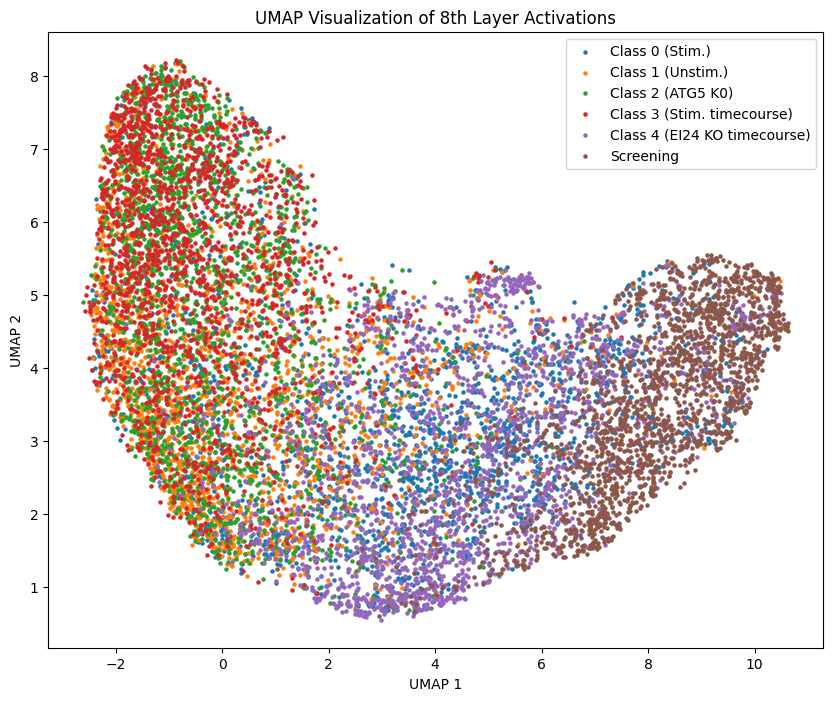

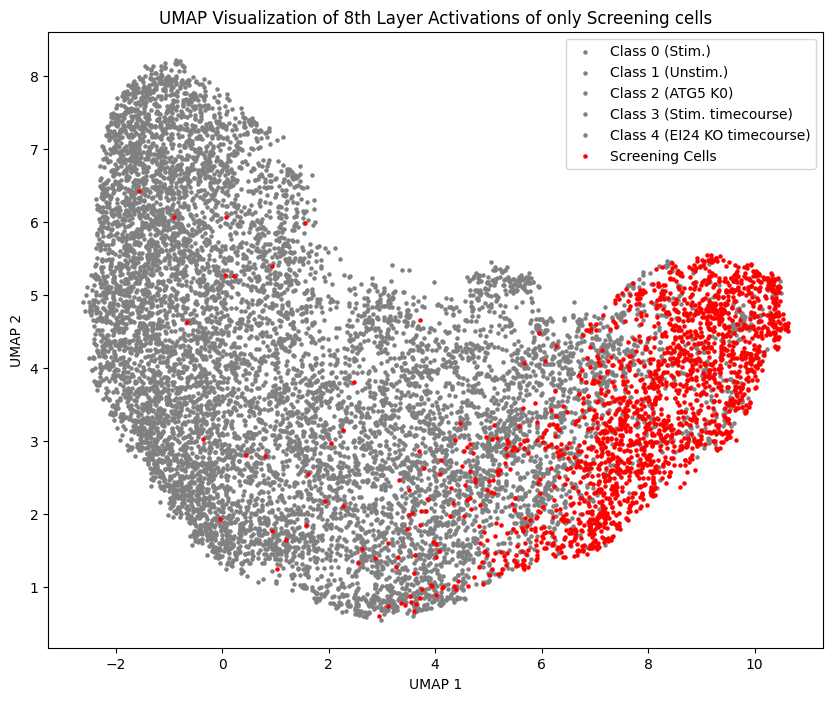

In [20]:
#Plotting UMAP using scatterplot instead of via scanpy
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)
plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()
plt.figure(figsize=(10, 8))

# Plot cells belonging to other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude the last class (screening)
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)
    
    
# Plot cells belonging to class 5 (screening) with red color
screening_idx = labels == 5
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], color='red', label='Screening Cells', s=5)

plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations of only Screening cells')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Determine the class index from the classification scores index
class_index = 0 
class_label = class_labels[class_index]
title = f'UMAP of 8th Layer Activations by Classification Scores for {class_label}'

##### Classification scores

In [21]:
#Load pretrained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
checkpoint_path = "VGG2_autophagy_classifier2.1.cpkt"
checkpoint = torch.load(checkpoint_path)
print(checkpoint.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [23]:
model = autophagy_classifier2_1(device)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
model.to(device)
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../workspace/SPARCSpy/src/pretrained_models/autophagy/autophagy2.1/VGG2_autophagy_classifier2.1.cpkt`


MultilabelSupervisedModel(
  (network): _VGG2(
    (norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (softmax): LogSoftmax(dim=1)
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, k

In [24]:
# Load the checkpoint
checkpoint_path = "VGG2_autophagy_classifier2.1.cpkt"
checkpoint = torch.load(checkpoint_path)
print(checkpoint.keys())

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize and load model
model = autophagy_classifier2_1(device)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
model.eval()

# Define the subset size and batch size
subset_size = 10000
batch_size = 256

# Load the subset indices
subset_indices = torch.load('ensemble_seed_202_Case_1_subset_indices.pth')

# Create a SubsetRandomSampler
subset_sampler = SubsetRandomSampler(subset_indices)

original_dataset = test_data_loader.dataset  # Access the underlying dataset from the DataLoader

# Create a new DataLoader for the subset
subset_data_loader = DataLoader(original_dataset, batch_size=batch_size, sampler=subset_sampler)

classification_scores = []
out_labels = []

# Calculate Classification Scores
with torch.no_grad():
    for data, labels in tqdm(subset_data_loader, desc="Calculating Scores", leave=False):
        data = data.to(device)
        logits = model(data)
        probabilities = torch.softmax(logits, dim=1)
        classification_scores.append(probabilities.cpu().detach().numpy())
        out_labels.append(labels.cpu().detach())

# Concatenate classification scores and labels from all batches
classification_scores = np.concatenate(classification_scores, axis=0)

Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../workspace/SPARCSpy/src/pretrained_models/autophagy/autophagy2.1/VGG2_autophagy_classifier2.1.cpkt`


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


Calculating Scores:   0%|          | 0/47 [00:00<?, ?it/s]

In [25]:
"""# Plot UMAP with cells colored by classification score
plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=classification_scores[:, class_index], cmap='viridis', s=5)
plt.colorbar(label='Classification Score')
plt.title(title)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

class_index = 0
plt.figure(figsize=(10, 8))

# Plot cells belonging to class 5 (screening) with color based on classification score
for i, label in enumerate(class_labels[:-1]): 
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Color the screening cells based on their classification score
cmap = plt.get_cmap('viridis')
screening_scores = classification_scores[screening_idx]
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], c=screening_scores[:, class_index], cmap=cmap, label='Screening Cells', s=5)
cbar = plt.colorbar()
cbar.set_label('Classification Score')

  
class_label = class_labels[class_index]
title = f'UMAP of 8th Layer Activations for Screening Cells with Classification Scores for {class_label}'

plt.title(title)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()"""

"# Plot UMAP with cells colored by classification score\nplt.figure(figsize=(10, 8))\nplt.scatter(umap_result[:, 0], umap_result[:, 1], c=classification_scores[:, class_index], cmap='viridis', s=5)\nplt.colorbar(label='Classification Score')\nplt.title(title)\nplt.xlabel('UMAP 1')\nplt.ylabel('UMAP 2')\nplt.show()\n\nclass_index = 0\nplt.figure(figsize=(10, 8))\n\n# Plot cells belonging to class 5 (screening) with color based on classification score\nfor i, label in enumerate(class_labels[:-1]): \n    idx = labels == i\n    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)\n\n# Color the screening cells based on their classification score\ncmap = plt.get_cmap('viridis')\nscreening_scores = classification_scores[screening_idx]\nplt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], c=screening_scores[:, class_index], cmap=cmap, label='Screening Cells', s=5)\ncbar = plt.colorbar()\ncbar.set_label('Classification Score')\n\n  \nclass_

In [26]:
# Save classification scores to a file
np.save('ensemble_seed_202_Case1_pretrained_original_autophagy_2_1_classification_scores.npy', classification_scores)

# Save out_labels as torch tensor
torch.save(out_labels, 'ensemble_seed_202_Case1_pretrained_original_autophagy_2_1_out_labels.pth')

In [ ]:
# Load scores and labels
classification_scores = np.load('Case1_pretrained_original_autophagy_2_1_classification_scores.npy')
out_labels = torch.load('Case1_pretrained_original_autophagy_2_1_out_labels.pth')

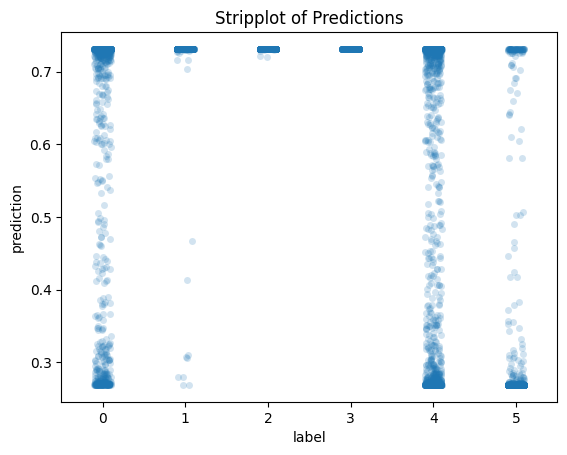

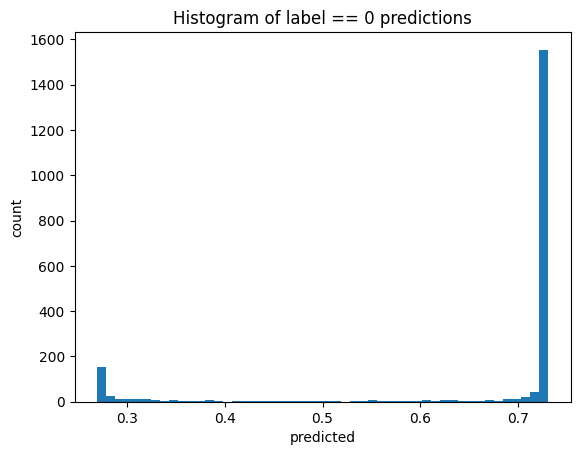

In [27]:
reform_labels = torch.hstack(out_labels)
reform_res = torch.tensor(classification_scores).softmax(dim=1)[:, 1]

#Strip Plot
sns.stripplot(x=reform_labels.numpy(), y=reform_res.numpy(), alpha=0.2)
plt.xlabel('label')
plt.ylabel('prediction')
plt.title('Stripplot of Predictions')
plt.show()

# Histogram
plt.hist(reform_res[reform_labels == 0].numpy(), bins=50)
plt.title('Histogram of label == 0 predictions')
plt.xlabel('predicted')
plt.ylabel('count')
plt.show()

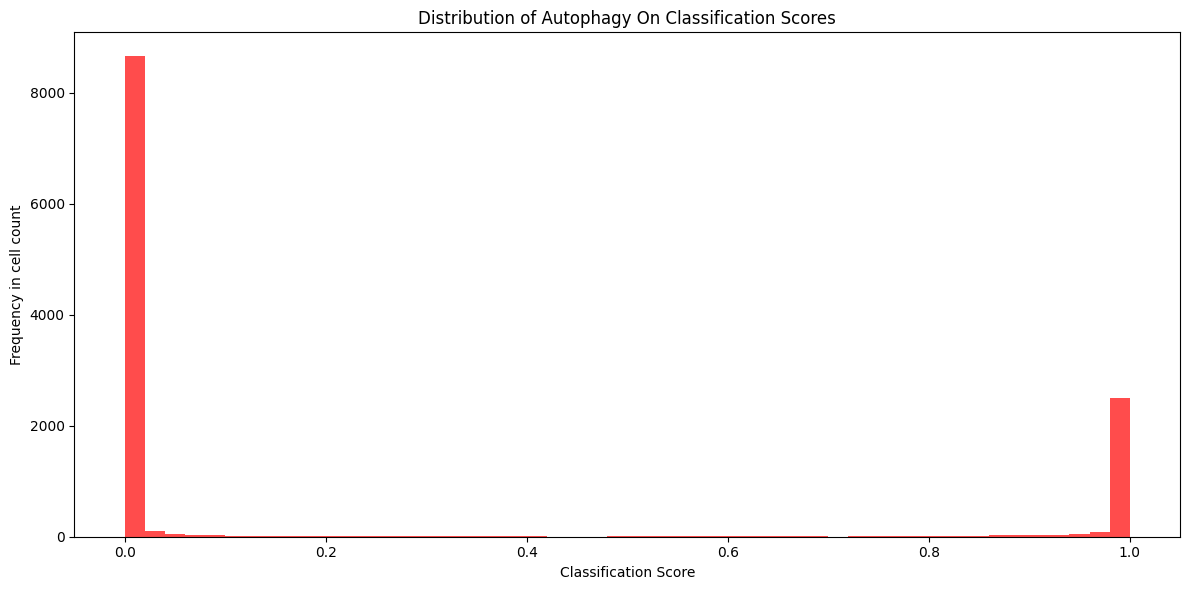

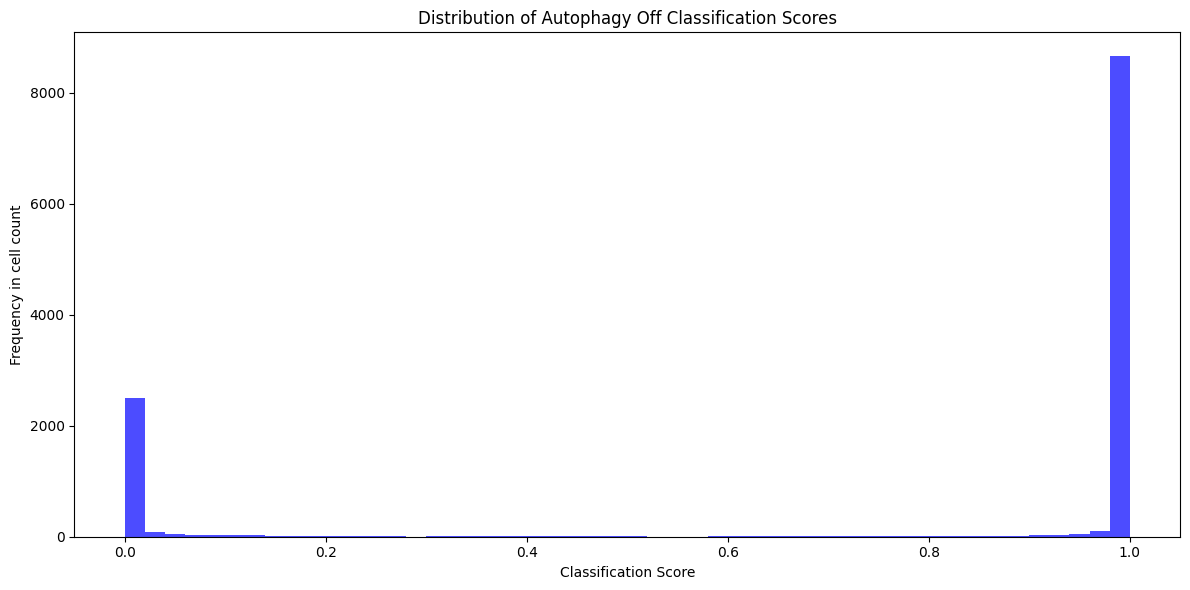

In [28]:
# Extract scores for autophagy on and off
autophagy_on_scores = classification_scores[:, 0]
autophagy_off_scores = classification_scores[:, 1]

# Plot for autophagy on
plt.figure(figsize=(12, 6))
plt.hist(autophagy_on_scores, bins=50, color='red', alpha=0.7)
plt.title('Distribution of Autophagy On Classification Scores')
plt.xlabel('Classification Score')
plt.ylabel('Frequency in cell count')
plt.tight_layout()
plt.show()

# Plot for autophagy off
plt.figure(figsize=(12, 6))
plt.hist(autophagy_off_scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Autophagy Off Classification Scores')
plt.xlabel('Classification Score')
plt.ylabel('Frequency in cell count')
plt.tight_layout()
plt.show()

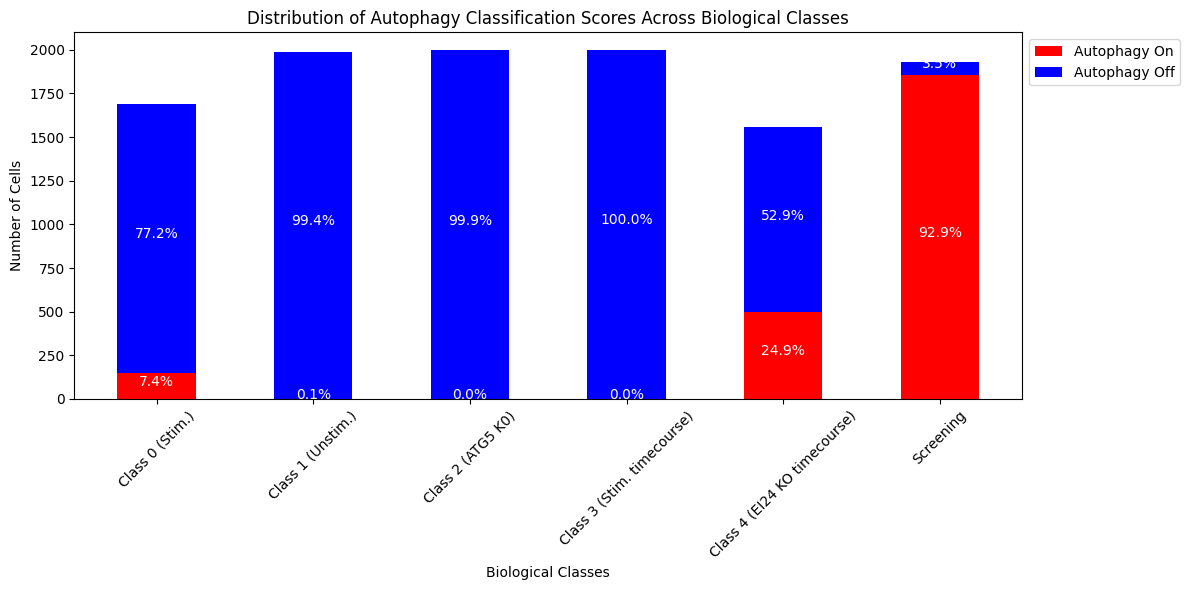

In [29]:
# Verify shape
assert classification_scores.shape[0] == reform_labels.shape[0], "Mismatch in number of samples between classification scores and labels"

# Initialize a dictionary to store counts for each biological class and autophagy label
counts = {bio_label: [0, 0] for bio_label in class_labels}
percentages = {bio_label: [0.0, 0.0] for bio_label in class_labels}

# Count the number of cells in each biological class with autophagy on or off
for i, bio_label in enumerate(class_labels):
    class_indices = (reform_labels == i).numpy()  # convert tensor to numpy for indexing
    total_count = np.sum(class_indices)
    autophagy_on_count = np.sum(classification_scores[class_indices, 0] > 0.98)  # Threshold for 'Autophagy on'
    autophagy_off_count = np.sum(classification_scores[class_indices, 1] > 0.98)  # Threshold for 'Autophagy off'
    counts[bio_label] = [autophagy_on_count, autophagy_off_count]
    if total_count > 0:
        percentages[bio_label] = [autophagy_on_count / total_count * 100, autophagy_off_count / total_count * 100]

# Extract counts for plotting
bio_classes = list(counts.keys())
autophagy_on_counts = [counts[bio_label][0] for bio_label in bio_classes]
autophagy_off_counts = [counts[bio_label][1] for bio_label in bio_classes]

plt.figure(figsize=(12, 6))
bar_width = 0.5
indices = np.arange(len(bio_classes))

plt.bar(indices, autophagy_on_counts, bar_width, label='Autophagy On', color='red')
plt.bar(indices, autophagy_off_counts, bar_width, bottom=autophagy_on_counts, label='Autophagy Off', color='blue')

# Add percentages to plot
for i, bio_label in enumerate(bio_classes):
    total = autophagy_on_counts[i] + autophagy_off_counts[i]
    if total > 0:
        plt.text(i, autophagy_on_counts[i] / 2, f'{percentages[bio_label][0]:.1f}%', ha='center', color='white')
        plt.text(i, autophagy_on_counts[i] + autophagy_off_counts[i] / 2, f'{percentages[bio_label][1]:.1f}%', ha='center', color='white')

plt.xlabel('Biological Classes')
plt.ylabel('Number of Cells')
plt.title('Distribution of Autophagy Classification Scores Across Biological Classes')
plt.xticks(indices, bio_classes, rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [30]:
"""class_indices = [0, 1]  # Autophagy on or off
class_labels = ["Class 0 (Autophagy on)", "Class 1 (Autophagy off)"]
num_classes = len(class_labels)

#class_labels

#Plotting UMAP using scatterplot instead of via scanpy
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)
plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


# Define class labels
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Screening)"]


#Plotting UMAP using scatterplot instead of via scanpy
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)
plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()
plt.figure(figsize=(10, 8))


# Plot UMAP with cells colored by classification score
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('viridis')  # Choose colormap (you can change it if needed)
for i, label in enumerate(class_labels):
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], c=classification_scores[idx, 0], cmap=cmap, label=label, s=5)

plt.title('UMAP Visualization of 8th Layer Activations Colored by Classification Score')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()


# Plot cells belonging to class 3 (screening) with red color
screening_idx = labels == 3
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], color='red', label='Screening Cells', s=5)

# Plot cells belonging to other classes in grey
for i, label in enumerate(class_labels[:-1]):  # Exclude the last class (screening)
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

plt.legend()
plt.title('UMAP Visualization of 8th Layer Activations of only Screening cells')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# Determine the class index from the classification scores index
class_index = 0 
class_label = class_labels[class_index]
title = f'UMAP of 8th Layer Activations by Classification Scores for {class_label}'

# Plot UMAP with cells colored by classification score
plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=classification_scores[:, class_index], cmap='viridis', s=5)
plt.colorbar(label='Classification Score')
plt.title(title)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

class_index = 0
plt.figure(figsize=(10, 8))

# Plot cells belonging to class 3 (screening) with color based on classification score
for i, label in enumerate(class_labels[:-1]): 
    idx = labels == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='grey', label=label, s=5)

# Color the screening cells based on their classification score
cmap = plt.get_cmap('viridis')
screening_scores = classification_scores[screening_idx]
plt.scatter(umap_result[screening_idx, 0], umap_result[screening_idx, 1], c=screening_scores[:, class_index], cmap=cmap, label='Screening Cells', s=5)
cbar = plt.colorbar()
cbar.set_label('Classification Score')"""

'class_indices = [0, 1]  # Autophagy on or off\nclass_labels = ["Class 0 (Autophagy on)", "Class 1 (Autophagy off)"]\nnum_classes = len(class_labels)\n\n#class_labels\n\n#Plotting UMAP using scatterplot instead of via scanpy\nplt.figure(figsize=(10, 8))\nfor i, label in enumerate(class_labels):\n    idx = labels == i\n    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)\nplt.legend()\nplt.title(\'UMAP Visualization of 8th Layer Activations\')\nplt.xlabel(\'UMAP 1\')\nplt.ylabel(\'UMAP 2\')\nplt.show()\n\n\n# Define class labels\nclass_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Screening)"]\n\n\n#Plotting UMAP using scatterplot instead of via scanpy\nplt.figure(figsize=(10, 8))\nfor i, label in enumerate(class_labels):\n    idx = labels == i\n    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)\nplt.legend()\nplt.title(\'UMAP Visualization of 8th Layer Activations\')\nplt.xlabel(\'UMAP 1\')\nplt.ylabel(\

In [31]:
"""# Define the number of screening indices
num_screening_indices = len(screening_indices)

plots_per_row = 7
num_rows = (num_screening_indices + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 5*num_rows))

# Iterate over the screening cells and plot the images
for i, (idx, sample, scores) in enumerate(zip(screening_indices, screening_cells_data, classification_scores), 1):
    image = sample[0][0]  
    
    # Calculate the row and column indices for the subplot grid
    row_idx = (i - 1) // plots_per_row
    col_idx = (i - 1) % plots_per_row
    
    # Plot the image
    axes[row_idx, col_idx].imshow(image, cmap='viridis')
    axes[row_idx, col_idx].set_title(f"Cell ID: {idx}")
    axes[row_idx, col_idx].axis('off')
    
    # Add classification scores as text
    axes[row_idx, col_idx].text(0.5, -0.2, f"Class 0 autophagy_2_1 Score: {scores[0]:.2f}", horizontalalignment='center', verticalalignment='center', transform=axes[row_idx, col_idx].transAxes)
    axes[row_idx, col_idx].text(0.5, -0.35, f"Class 1 autophagy_2_1 Score: {scores[1]:.2f}", horizontalalignment='center', verticalalignment='center', transform=axes[row_idx, col_idx].transAxes)
plt.tight_layout()
plt.show()"""

'# Define the number of screening indices\nnum_screening_indices = len(screening_indices)\n\nplots_per_row = 7\nnum_rows = (num_screening_indices + plots_per_row - 1) // plots_per_row\nfig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 5*num_rows))\n\n# Iterate over the screening cells and plot the images\nfor i, (idx, sample, scores) in enumerate(zip(screening_indices, screening_cells_data, classification_scores), 1):\n    image = sample[0][0]  \n    \n    # Calculate the row and column indices for the subplot grid\n    row_idx = (i - 1) // plots_per_row\n    col_idx = (i - 1) % plots_per_row\n    \n    # Plot the image\n    axes[row_idx, col_idx].imshow(image, cmap=\'viridis\')\n    axes[row_idx, col_idx].set_title(f"Cell ID: {idx}")\n    axes[row_idx, col_idx].axis(\'off\')\n    \n    # Add classification scores as text\n    axes[row_idx, col_idx].text(0.5, -0.2, f"Class 0 autophagy_2_1 Score: {scores[0]:.2f}", horizontalalignment=\'center\', verticalalignment=\'center\'

In [30]:
#Save the adata
adata.write('ensemble_seed_202_Case1_adata.h5ad')